In [1]:
# import modules and get pwd

import pymysql
from sqlalchemy import create_engine
import pandas as pd
import getpass  # To get the password without showing the input
password = getpass.getpass()
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix


········


The features retrieved below will form (X) for our model training set

In [2]:
# retrive and frame (X) data from sql

connection_string = 'mysql+pymysql://root:' + password + '@localhost/sakila'

engine = create_engine(connection_string)

query = '''SELECT f.film_id, f.title, f.rental_rate, f.special_features, f.rental_duration, f.length, f.rating,
            f.language_id FROM film AS f'''



data = pd.read_sql_query(query, engine)
data.head()

,film_id,title,rental_rate,special_features,rental_duration,length,rating,language_id
0,1,ACADEMY DINOSAUR,0.99,"Deleted Scenes,Behind the Scenes",6,86,PG,1
1,2,ACE GOLDFINGER,4.99,"Trailers,Deleted Scenes",3,48,G,1
2,3,ADAPTATION HOLES,2.99,"Trailers,Deleted Scenes",7,50,NC-17,1
3,4,AFFAIR PREJUDICE,2.99,"Commentaries,Behind the Scenes",5,117,G,1
4,5,AFRICAN EGG,2.99,Deleted Scenes,6,130,G,1


Now let's define the query to retrive the data for our target variable (y)

In [3]:
# retrieve and frame (y) data from sql

query_y = '''SELECT f.film_id, f.title, 
            MAX(CASE WHEN r.rental_date between '2005-05-01' AND '2005-05-31' THEN 1 ELSE 0 END) 
            AS rented_in_may FROM film AS f 
            LEFT JOIN inventory AS i ON f.film_id = i.film_id LEFT JOIN rental AS r
            ON i.inventory_id = r.inventory_id GROUP BY f.film_id, f.title'''

data_y = pd.read_sql_query(query_y, engine)
data_y.head()

,film_id,title,rented_in_may
0,1,ACADEMY DINOSAUR,1
1,2,ACE GOLDFINGER,0
2,3,ADAPTATION HOLES,0
3,4,AFFAIR PREJUDICE,1
4,5,AFRICAN EGG,1


In [4]:
data_y.shape

(1000, 3)

In [5]:
# join the dataframes

merged_data = pd.merge(data, data_y, how='left')
merged_data

,film_id,title,rental_rate,special_features,rental_duration,length,rating,language_id,rented_in_may
0,1,ACADEMY DINOSAUR,0.99,"Deleted Scenes,Behind the Scenes",6,86,PG,1,1
1,2,ACE GOLDFINGER,4.99,"Trailers,Deleted Scenes",3,48,G,1,0
2,3,ADAPTATION HOLES,2.99,"Trailers,Deleted Scenes",7,50,NC-17,1,0
3,4,AFFAIR PREJUDICE,2.99,"Commentaries,Behind the Scenes",5,117,G,1,1
4,5,AFRICAN EGG,2.99,Deleted Scenes,6,130,G,1,1
...,...,...,...,...,...,...,...,...,...
995,996,YOUNG LANGUAGE,0.99,"Trailers,Behind the Scenes",6,183,G,1,0
996,997,YOUTH KICK,0.99,"Trailers,Behind the Scenes",4,179,NC-17,1,0
997,998,ZHIVAGO CORE,0.99,Deleted Scenes,6,105,NC-17,1,1
998,999,ZOOLANDER FICTION,2.99,"Trailers,Deleted Scenes",5,101,R,1,1


In [6]:
# check the number of May rentals

merged_data['rented_in_may'].value_counts()

1    627
0    373
Name: rented_in_may, dtype: int64

I am selecting the following features for examination ['rental_duration', 'length', 'rental_rate', 'rating']

In [7]:
# new dataframe dropping uneeded columns

selected_columns = ['rental_duration', 'length', 'rental_rate', 'rating', 'rented_in_may']
df = merged_data[selected_columns]


In [8]:
# serach for null values

df.isna().sum()

rental_duration    0
length             0
rental_rate        0
rating             0
rented_in_may      0
dtype: int64

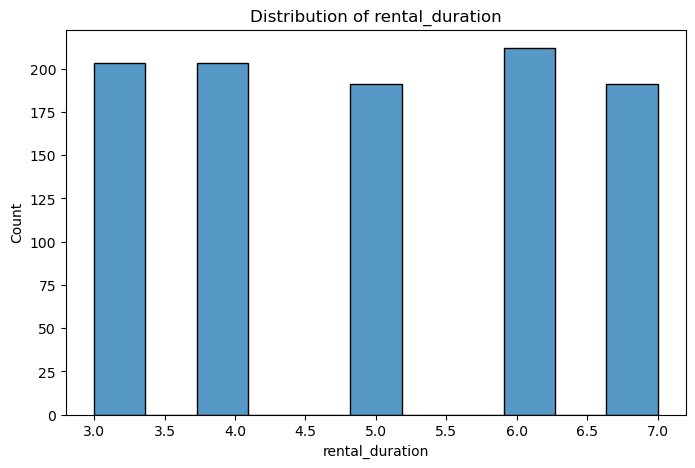

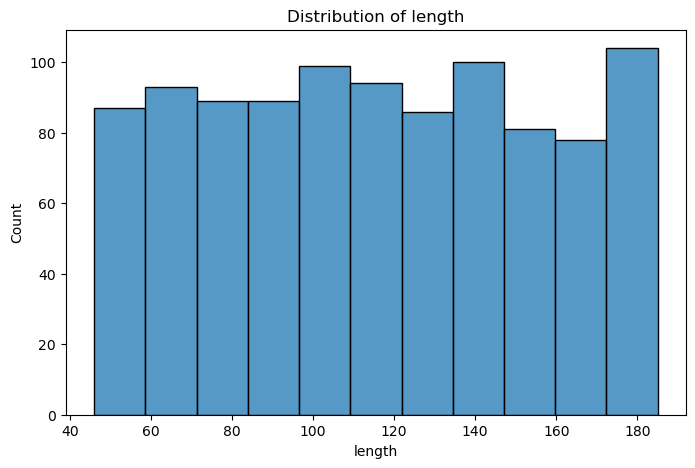

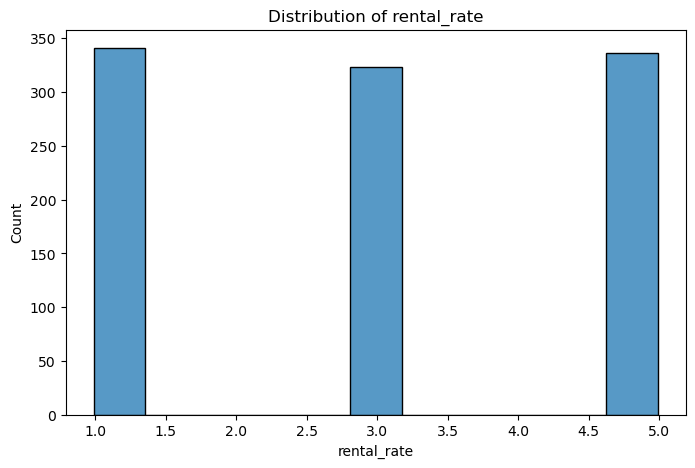

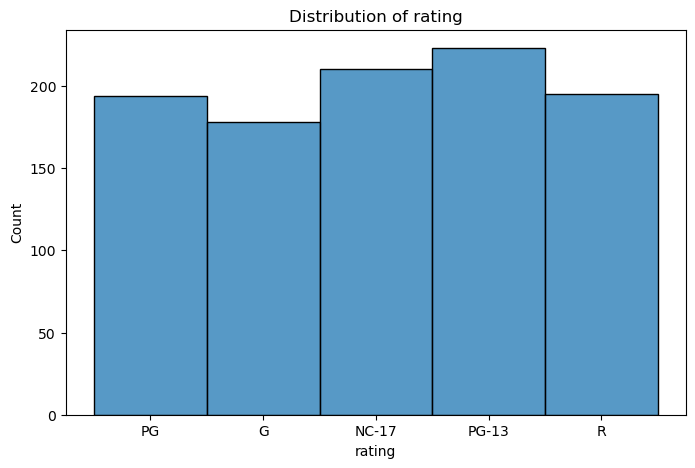

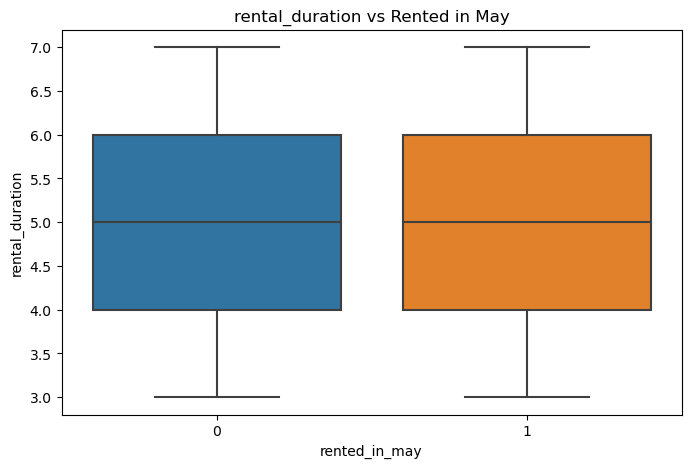

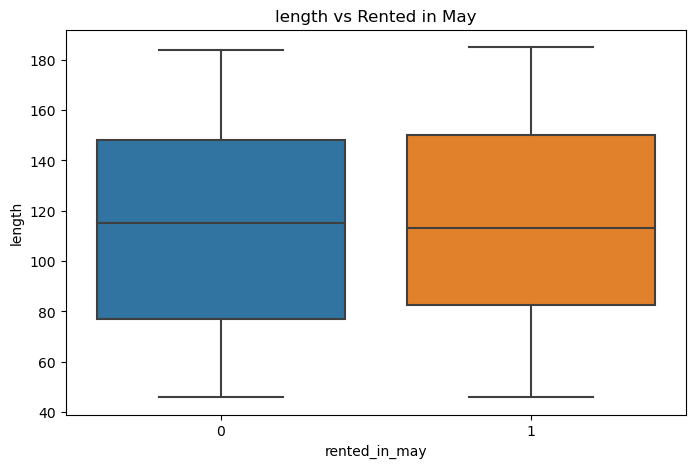

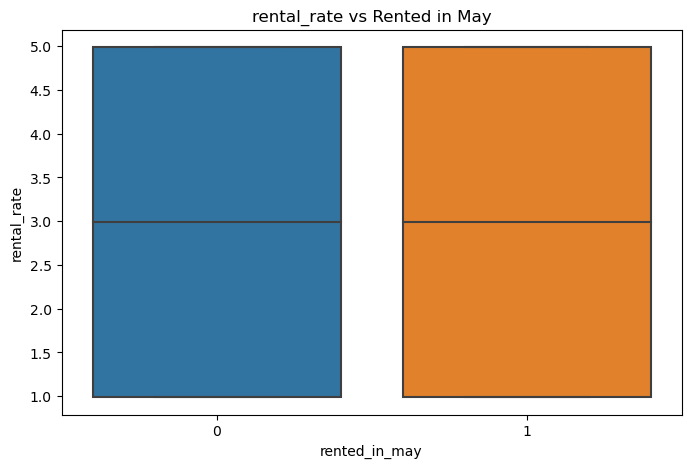

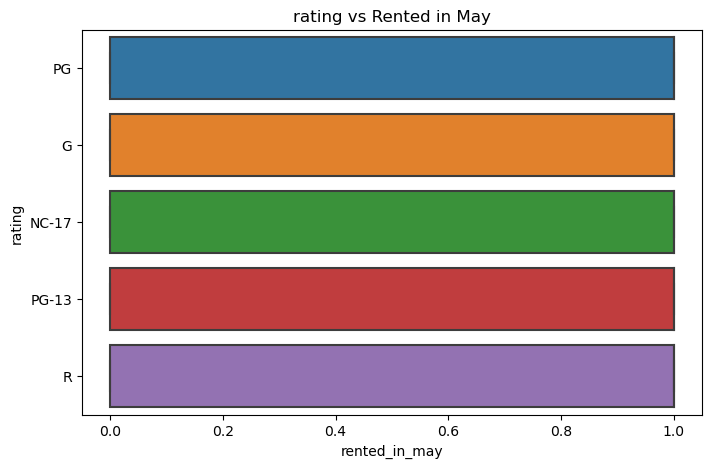

In [9]:
# examine the distributions of the features

features = ['rental_duration', 'length', 'rental_rate', 'rating']
for feature in features:
    plt.figure(figsize=(8,5))
    sns.histplot(merged_data[feature])
    plt.title(f'Distribution of {feature}')
    plt.show()

# exmaine the relationships of these features with 'rented_in_may'

for feature in features:
    plt.figure(figsize=(8,5))
    sns.boxplot(x='rented_in_may', y=feature, data=merged_data)
    plt.title(f'{feature} vs Rented in May')
    plt.show()


In [10]:
# one-hot encoding for rating

df = pd.get_dummies(df, columns=['rating'], drop_first=True)


# scaling numerical variables

scaler = MinMaxScaler()
df[features[:-1]] = scaler.fit_transform(df[features[:-1]])



In [11]:
#split the data into train and test sets

X = df[features[:-1]]  # Using all features except the last one (assuming 'rented_in_may' is the last in the list)
y = df['rented_in_may']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)


In [12]:
# log. regression model

log_reg = LogisticRegression()

In [13]:
#train the model

log_reg.fit(X_train, y_train)

LogisticRegression()

In [14]:
# predict on the test set
y_pred = log_reg.predict(X_test)

Accuracy: 62.00%
              precision    recall  f1-score   support

           0       1.00      0.00      0.00       114
           1       0.62      1.00      0.77       186

    accuracy                           0.62       300
   macro avg       0.81      0.50      0.38       300
weighted avg       0.76      0.62      0.47       300



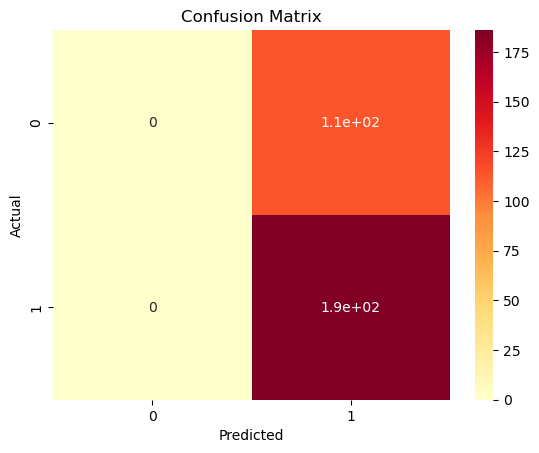

In [16]:
# check the accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy*100:.2f}%")

# Print classification report with zero_division=1 to omit 0 vales for rented in may.

from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred, zero_division=1))

# heatmap of the confusion matrix

sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, cmap="YlOrRd")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()


At 0.62, this tells us that when the model predicts a movie will be rented, it's right 62% of the time. We could use this information to support business decisions regarding inventory and promotions.

In situations where both FPs (mistakenly predicting a rental) and FNs (missing out on predicting a rental) have business consequences, we might need to balance things. We might be more ilkely to accept some FPs for the sake of capturing all actual rentals.